# TASK 2  - Dimensionality reduction

## Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

from sklearn.preprocessing import LabelEncoder

from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import umap

import pickle

from sklearn.neighbors import KernelDensity

## Helper functions

In [5]:
def get_cells_of_group_without_columns(df, group, columns):
    return df[df.group == group][df.columns.difference(columns)]

def get_cells_of_patient_without_columns(df, id_, columns):
    return df[df.id == id_][df.columns.difference(columns)]

## Possible candidates
- tsne
- umap
- MDS

## Plot an embedding trained on a sample of the data
- The reduction algrithms are trained on both "control" and "diseased" cells combined.

## Import files

In [2]:
dfs = pd.read_csv("ModifiedDATA/scaled_ra.csv")

In [18]:
dfs.describe()

,145Nd_CD4,146Nd_CD8a,147Sm_CD20,148Nd_CD16,151Eu_CD123,159Tb_CD11c,160Gd_CD14,169Tm_CD45RA,170Er_CD3,174Yb_HLA-DR,176Yb_CD56,209Bi_CD61,id
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,1.150588,1.333476,0.118680,0.085666,0.095650,0.671779,0.307882,1.880021,2.817956,0.984007,0.604480,0.485726,20.500000
std,1.220329,1.838250,0.419028,0.282540,0.385329,1.359591,0.853568,1.754079,1.905254,1.686048,1.114777,1.217038,11.543404
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034593,0.222168,0.000000,0.000000,0.000000,10.750000
50%,0.452590,0.380735,0.000000,0.000000,0.000000,0.000000,0.000000,1.471067,3.798173,0.000000,0.022598,0.000000,20.500000
75%,2.432927,1.983169,0.000000,0.000000,0.000000,0.396897,0.000000,3.459549,4.315451,0.982516,0.592855,0.109779,30.250000
max,6.689613,9.361942,6.185456,9.160339,5.356280,6.788544,5.775514,7.477199,6.020727,8.772834,6.866529,9.270154,40.000000


In [19]:
# subsample df
sample_size = 8000
subsample = dfs.sample(sample_size)
sTrain = subsample[dfs.columns.difference(["id","group"])]

leG = LabelEncoder()
label_group = leG.fit_transform(subsample.group)

leI = LabelEncoder()
label_id = leI.fit_transform(subsample.id)

In [12]:
# Plot embedding
def plotRes(res):
    res_df = pd.DataFrame(res, columns=["fstAxis","sndAxis"])
    res_df["label"]=label_group
    X1 = res_df.where(res_df.label == leG.transform(["control"])[0])
    X2 = res_df.where(res_df.label == leG.transform(["diseased"])[0])

    plt.scatter(X1.fstAxis, X1.sndAxis, c=X1.label)
    plt.title("control")
    plt.show()
    
    plt.scatter(X2.fstAxis, X2.sndAxis, c=X2.label, cmap="RdBu")
    plt.title("diseased")
    plt.show()

## TSNE of standardized data

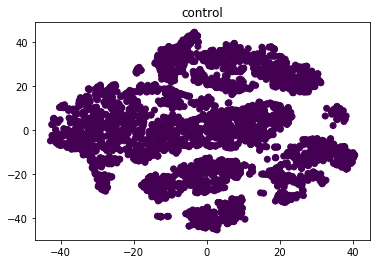

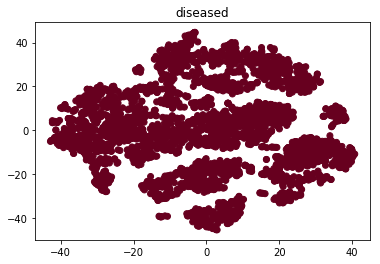

In [20]:
tsne = TSNE(n_components=2, perplexity=30, 
            learning_rate=20, n_iter=1000, 
            random_state=0)
res = tsne.fit_transform(sTrain)
plotRes(res)

## UMAP of standardized data

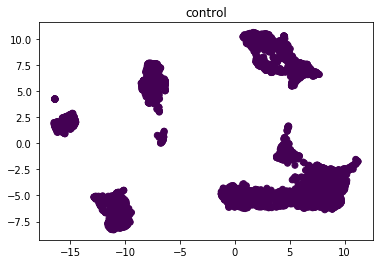

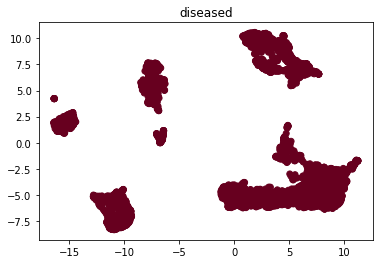

In [21]:
up = umap.UMAP(n_components=2, n_neighbors=10, random_state=0)
res = up.fit_transform(sTrain)
plotRes(res)

### MDS

In [ ]:
mds = MDS(n_components=2, dissimilarity='euclidean')
mds_data = mds.fit_transform(sTrain)
plotRes(res)

### NOTE: 
- The result suggests possibly at least 6 clusters, even though this is just a subsampling. from this we can fit a gmm with 6 components and compare it to gmm with fewer and more components.

## Group by id and plot the demsionality reduction

In [22]:
def plotResP(ax, res, id_nr):
    if(id_nr >20): 
        color= "red" # control patients
    else: 
        color ="green" # diseased patients
    ax.scatter(res[:,0], res[:,1], c=color)
    ax.set_title(id_nr)

### Grouping

In [24]:
tSNE_ = []
UMAP_ = []

tsne = TSNE(n_components=2, perplexity=30, 
            learning_rate=20, n_iter=1000, 
            random_state=0)
up = umap.UMAP(n_components=2, n_neighbors=10, random_state=0)

for i in range(1,41):
    person = dfs[dfs.id == i]
    persons_cells = person[person.columns.difference(["id","group"])]
    tSNE_.append(tsne.fit_transform(persons_cells))
    UMAP_.append(up.fit_transform(persons_cells))

KeyboardInterrupt: 

### Saving to file

In [9]:
np.save("tSNE_",tSNE_)
np.save("UMAP_",UMAP_)

## Helper function for ploting

In [7]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

### TSNE embedding of each patient

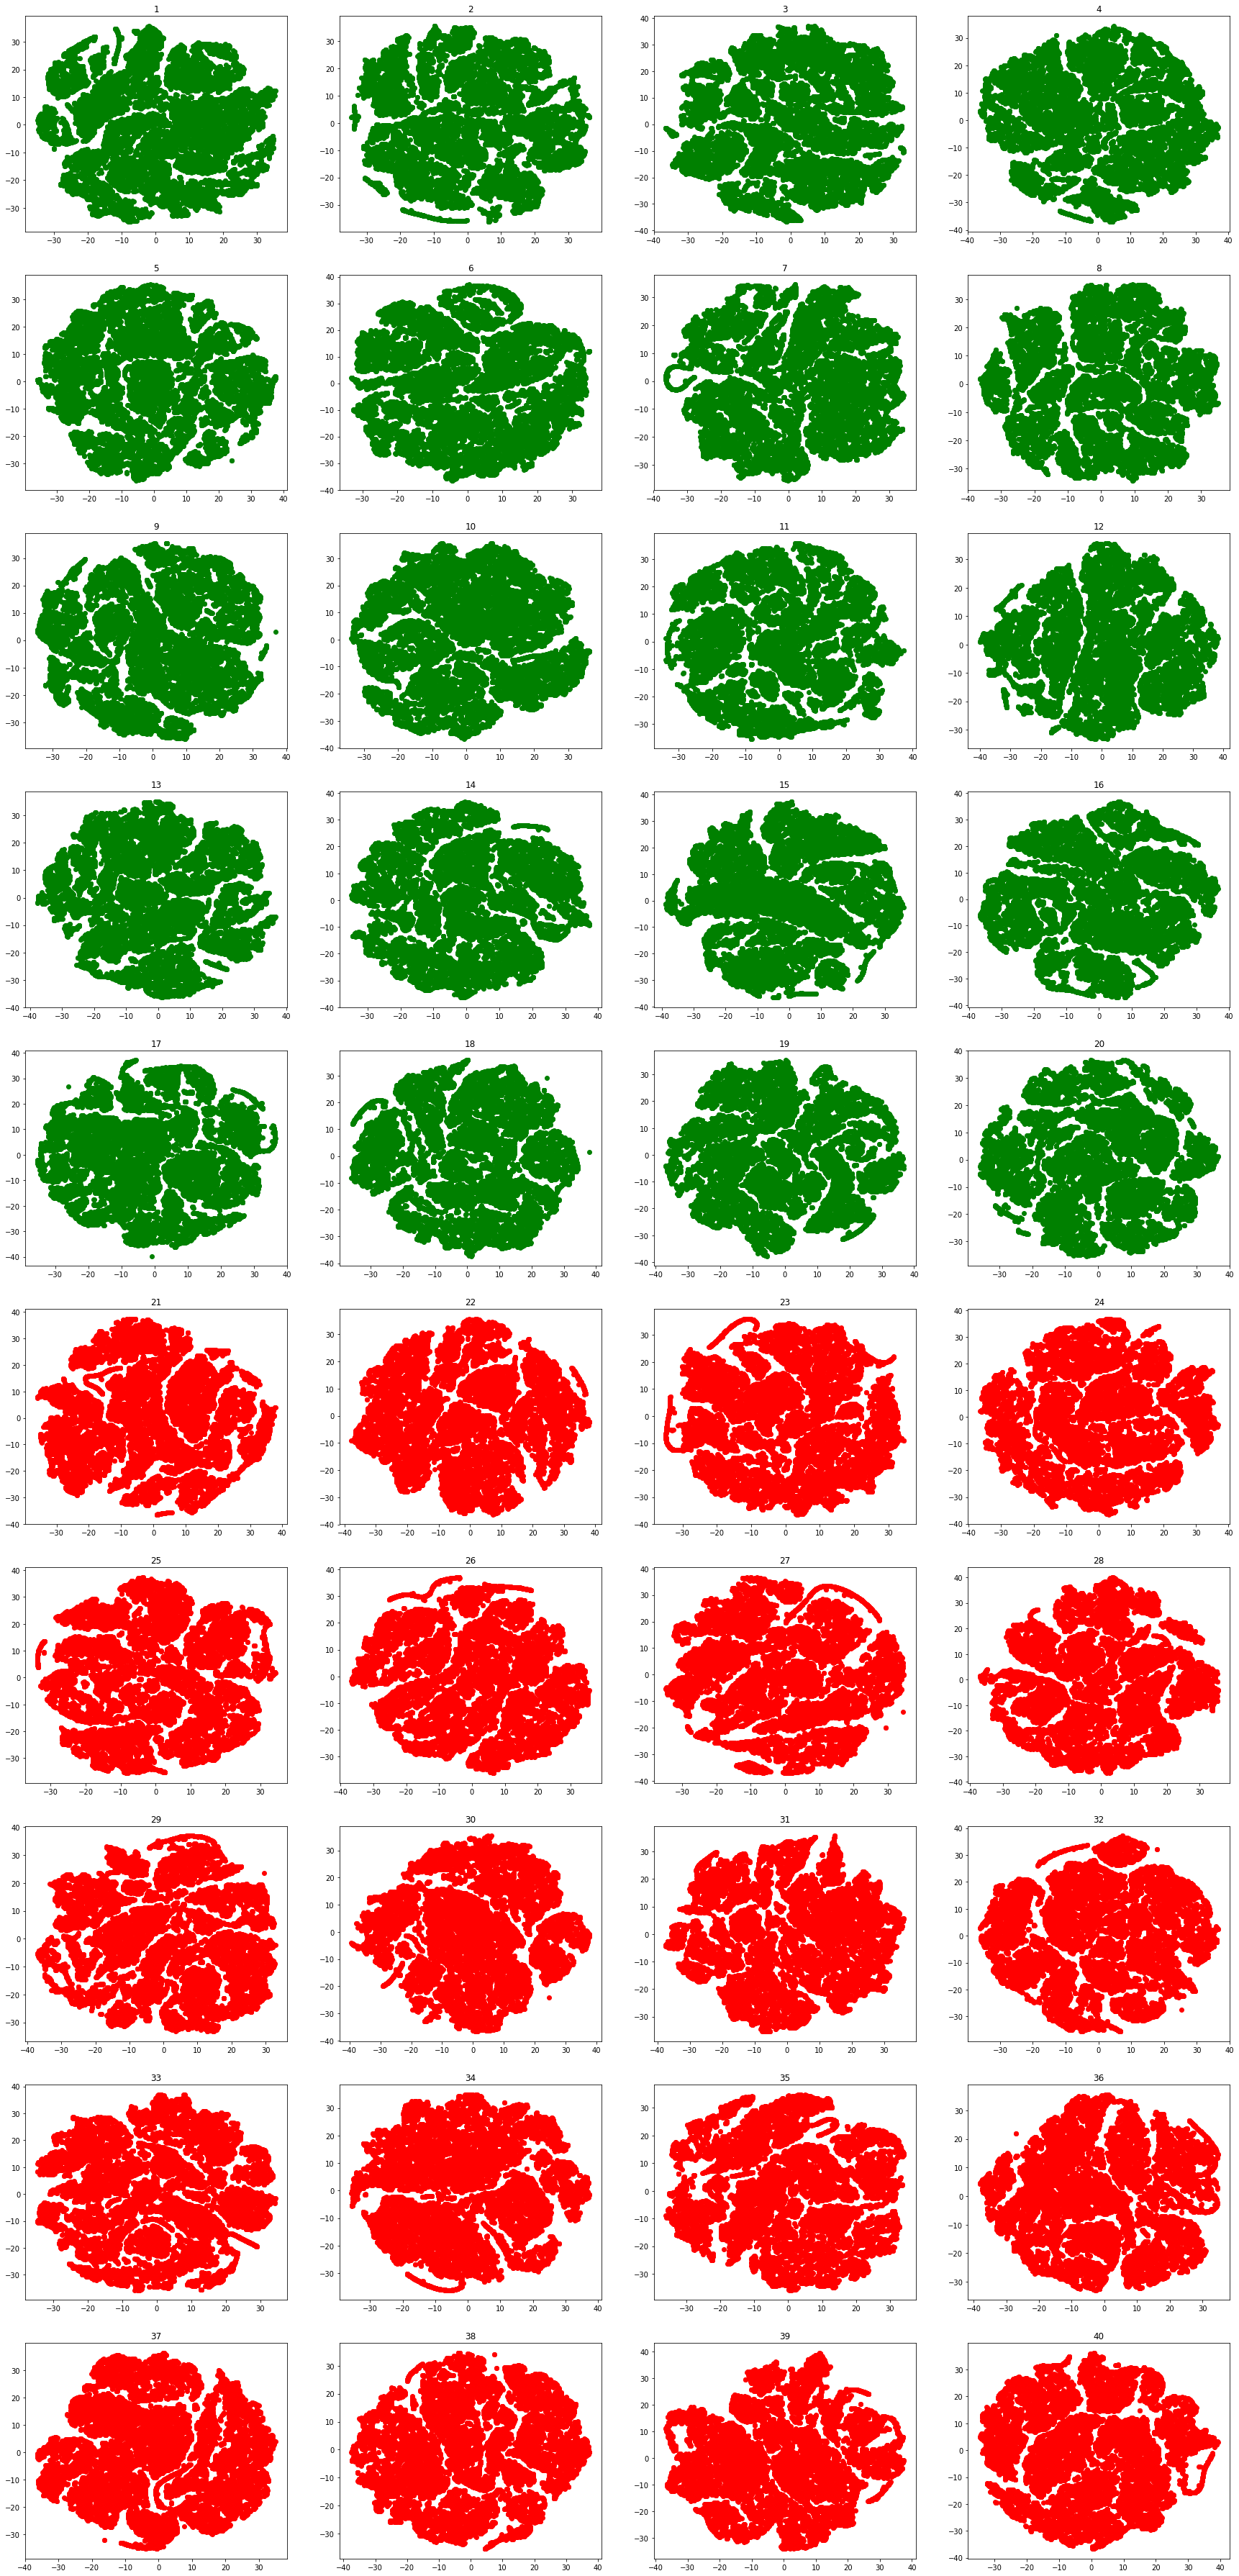

In [12]:
fig, axs = plt.subplots(10,4,figsize = (30,65))
axs = trim_axs(axs, 40)
for ax, (i, res) in zip(axs, enumerate(tSNE_)):
    plotResP(ax, res, i+1)
    plt.show

### UMAP embedding of each patient

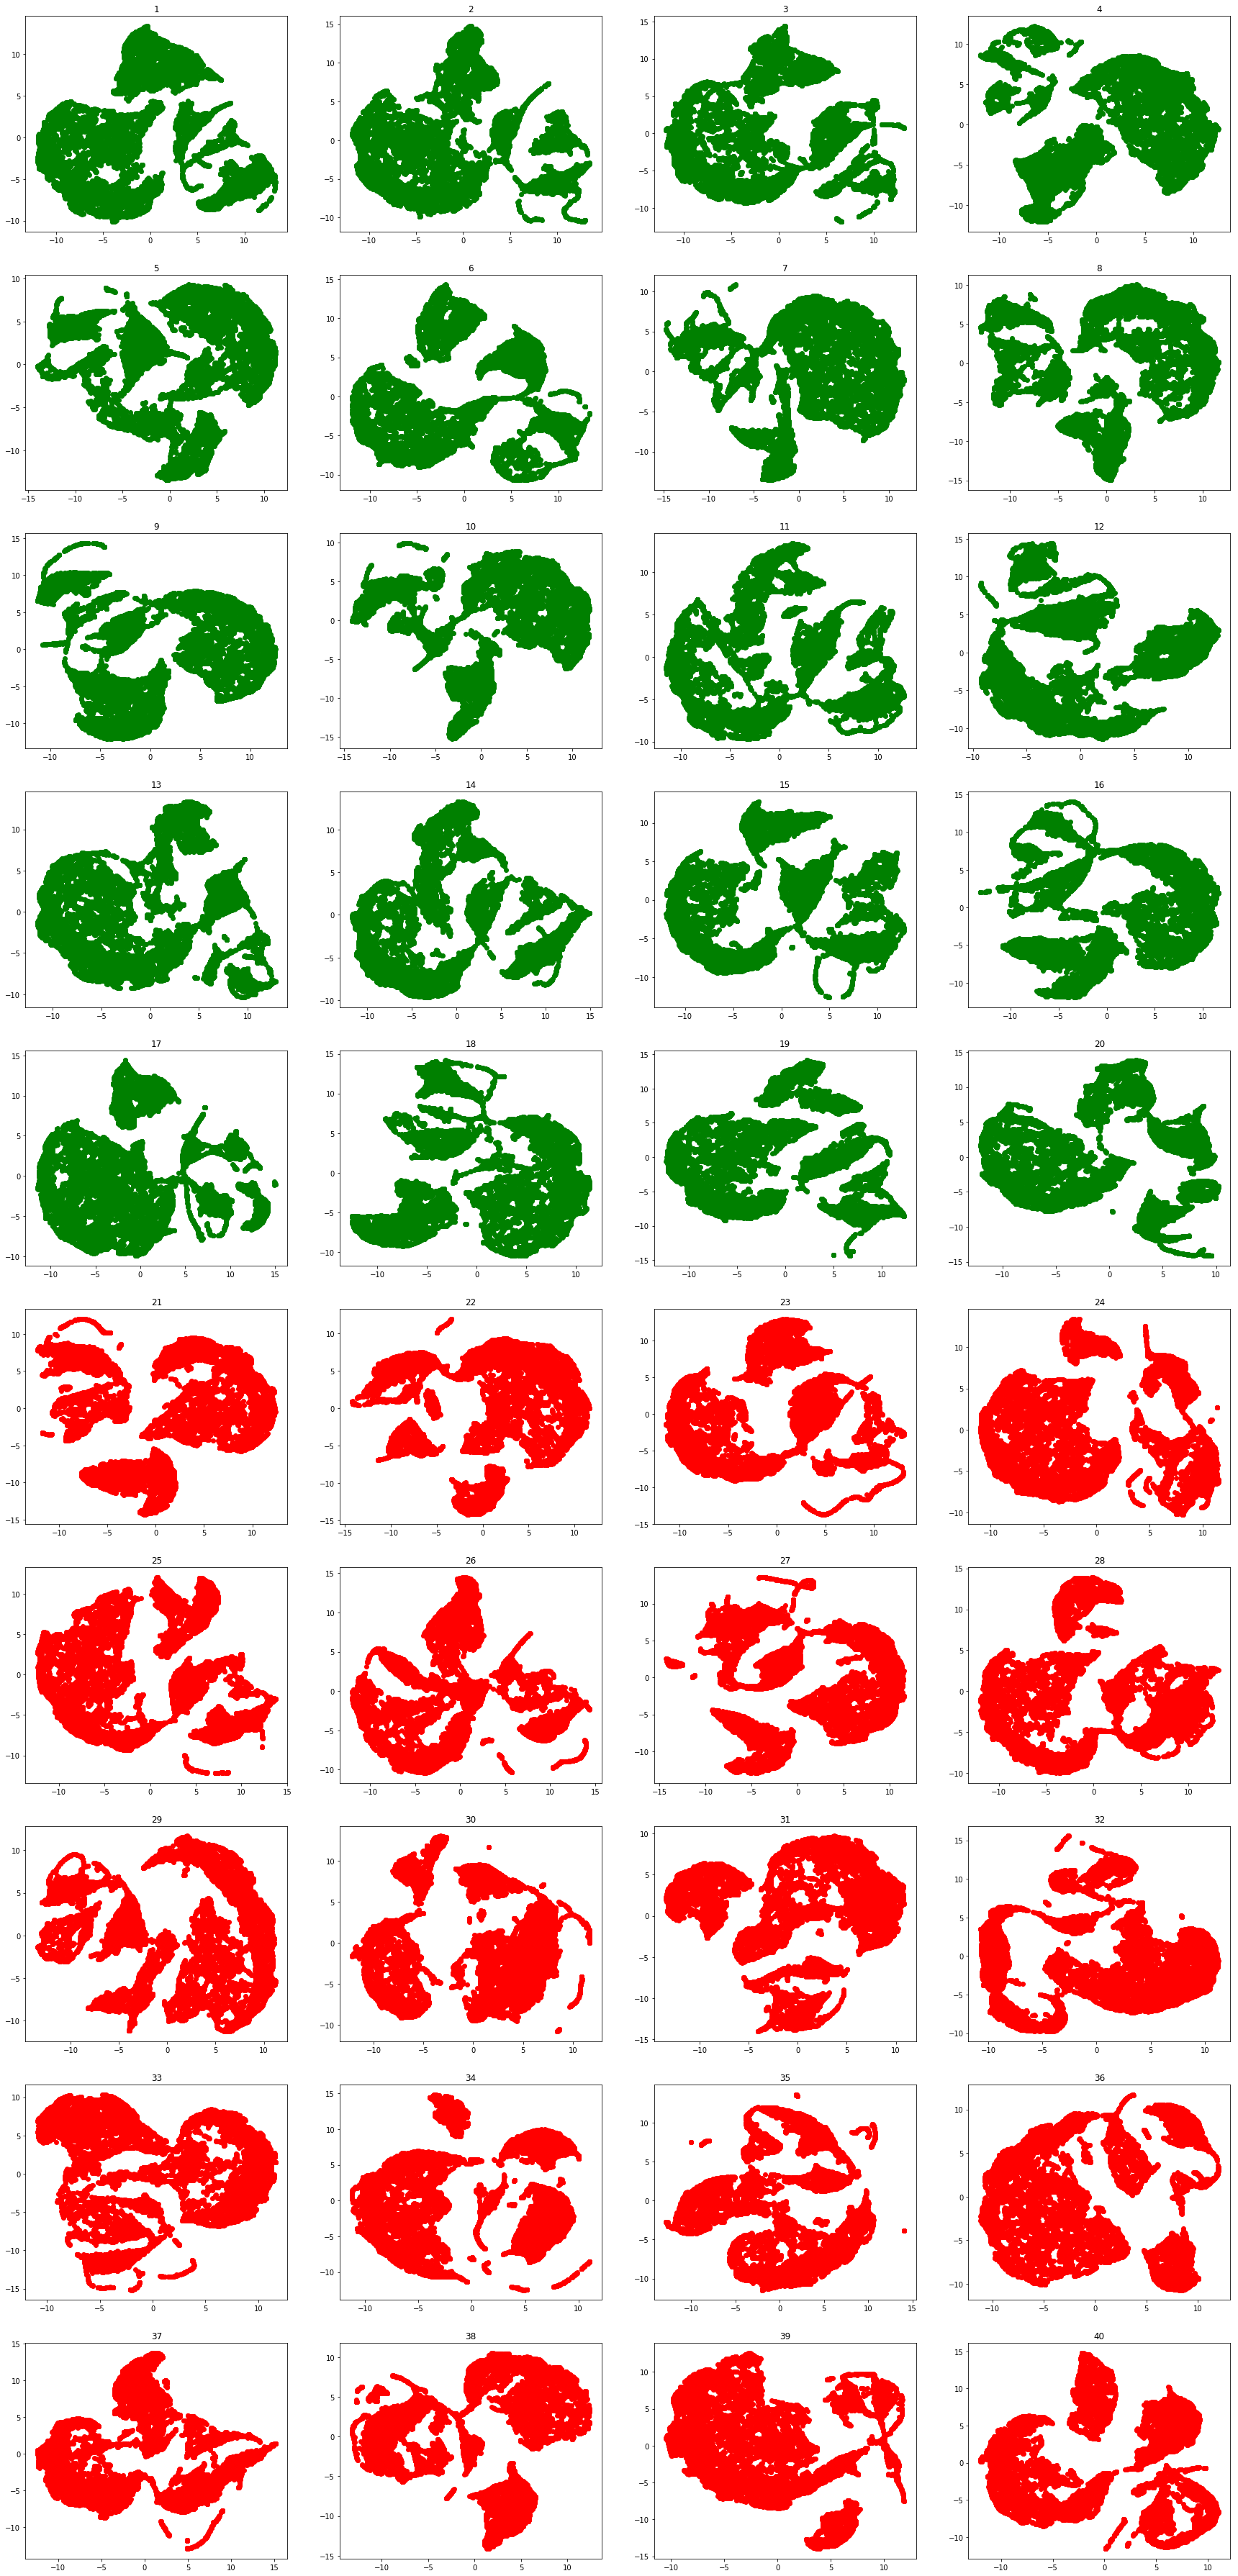

In [13]:
fig, axs = plt.subplots(10,4,figsize = (30,65))
axs = trim_axs(axs, 40)
for ax, (i, res) in zip(axs, enumerate(UMAP_)):
    plotResP(ax, res, i+1)
    plt.show

## Plot control and diseased using tSNE and UMAP
- The embedding algorithms are trainded on "control" and "diseased" cells seperated

In [19]:
sick_control_tSNE_ = []
sick_control_UMAP_ = []

tsne = TSNE(n_components=2, perplexity=30, 
            learning_rate=20, n_iter=1000, 
            random_state=0)
up = umap.UMAP(n_components=2, n_neighbors=10, random_state=0)

for g in ["control","diseased"]:
    group = df[df.group == g]
    group_cells = group[group.columns.difference(["id","group"])]
    sick_control_tSNE_.append(tsne.fit_transform(group_cells))
    sick_control_UMAP_.append(up.fit_transform(group_cells))

In [20]:
np.save("sick_control_tSNE_",sick_control_tSNE_)
np.save("sick_control_UMAP_",sick_control_UMAP_)

### TSNE

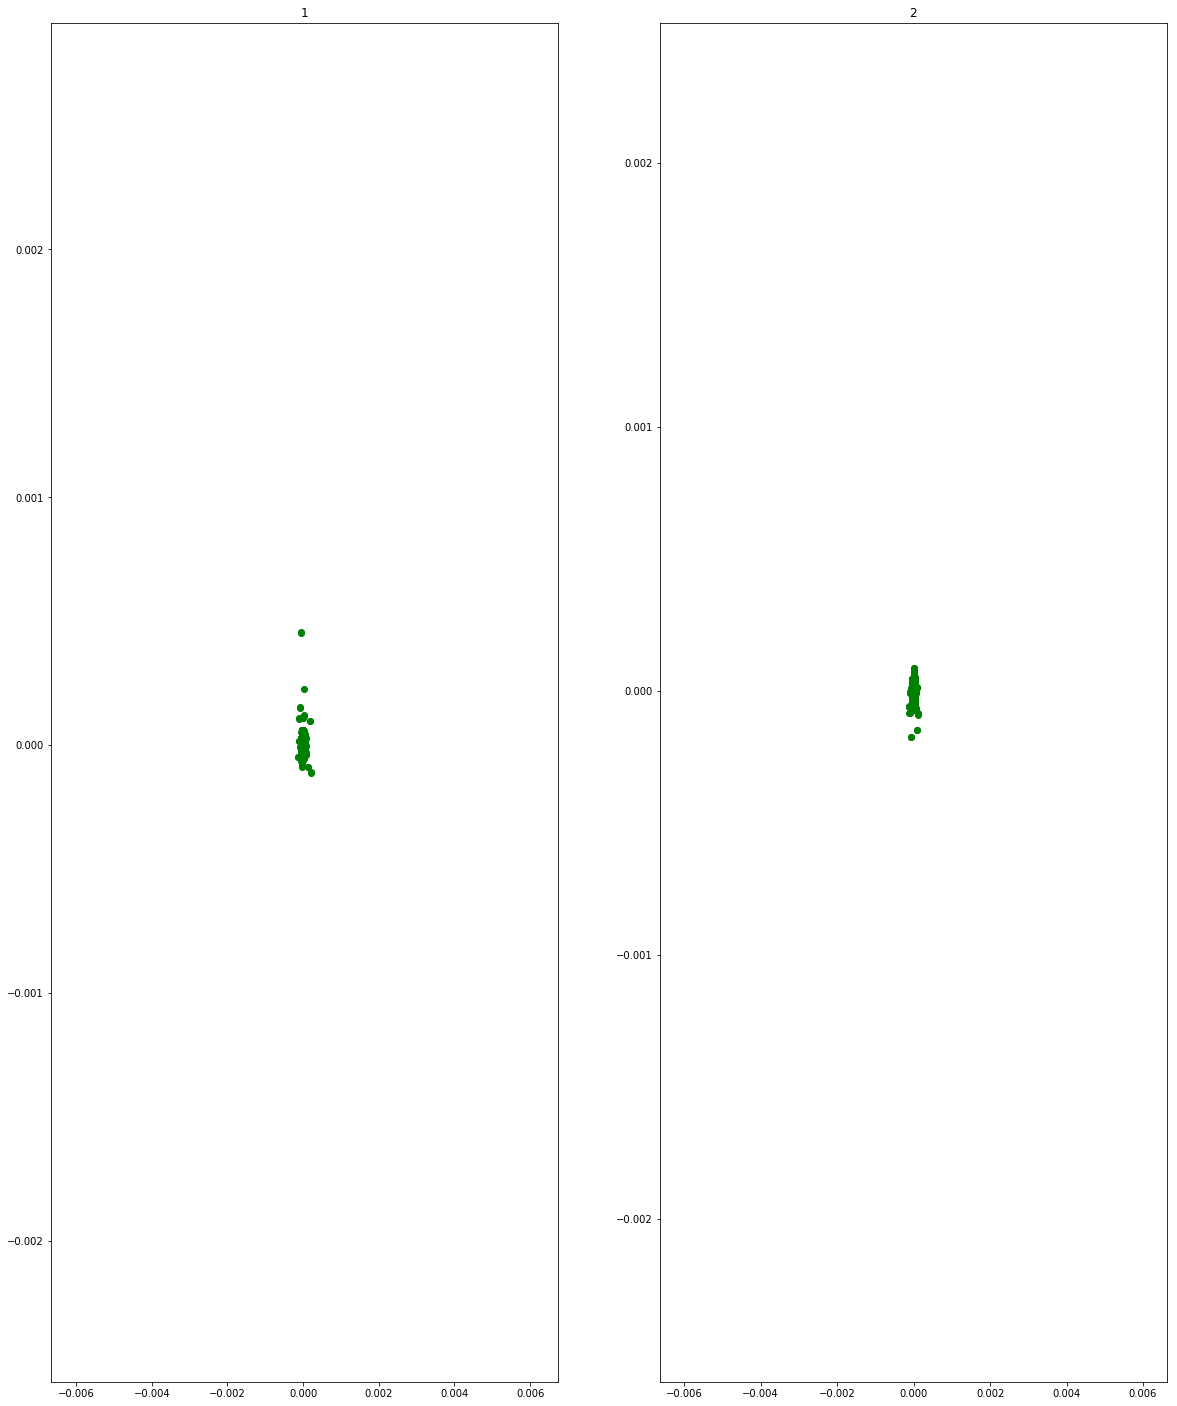

In [35]:
fig, axs = plt.subplots(1,2,figsize = (20,25))
axs = trim_axs(axs, 2)
for ax, (i, res) in zip(axs, enumerate(sick_control_tSNE_)):
    plotResP(ax, res, i+1)
    plt.show

<h4 style ="color:red">Why does TSNE project this way?</h4>

### UMAP

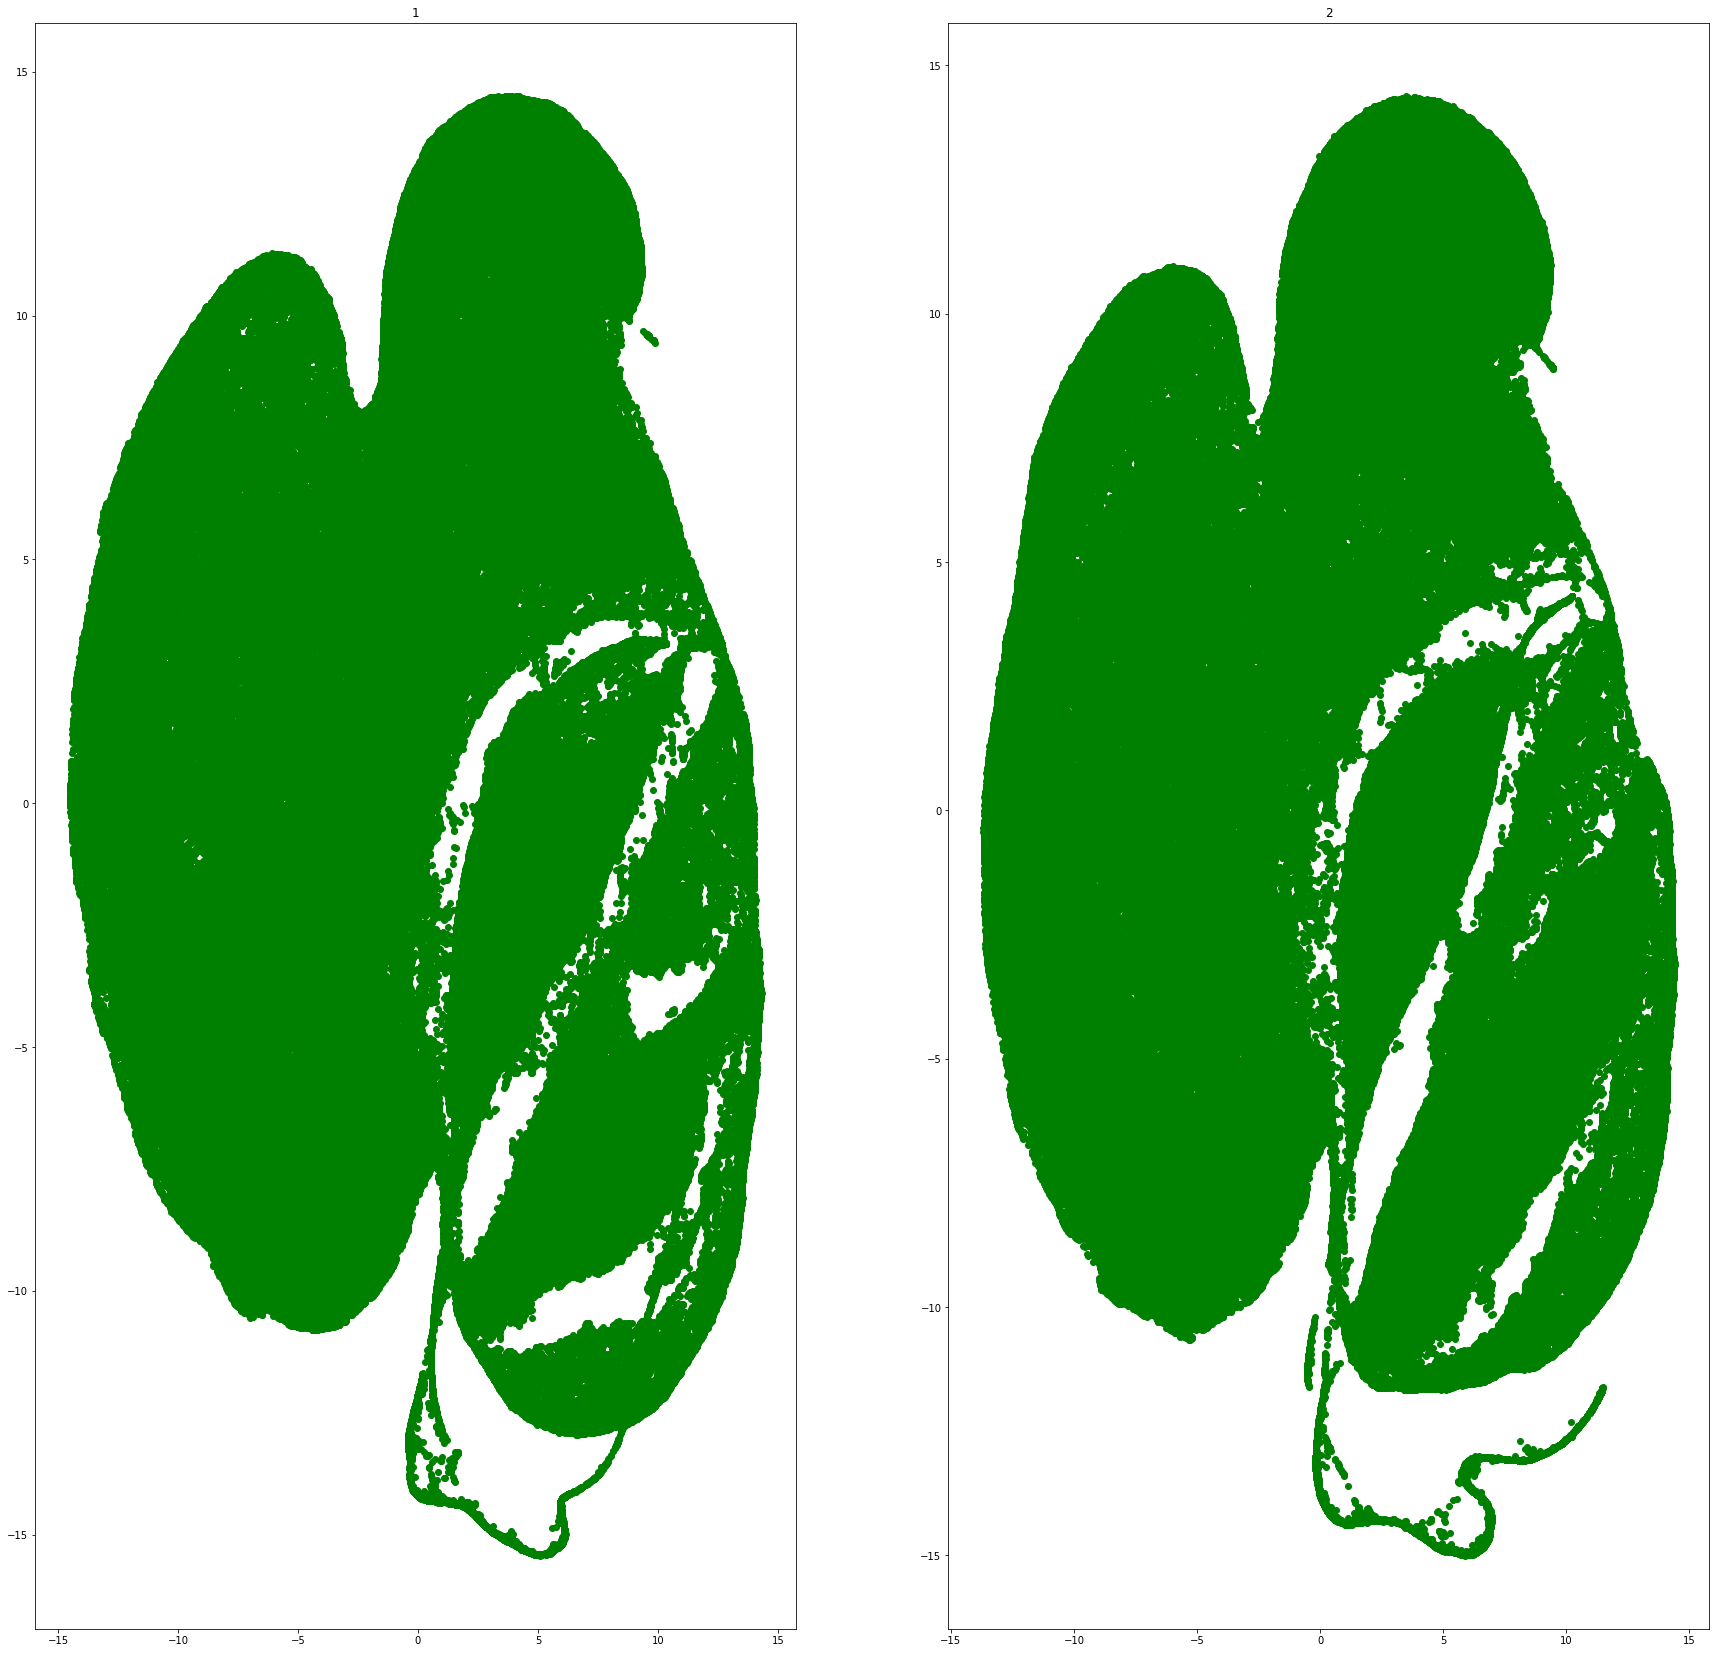

In [24]:
fig, axs = plt.subplots(2,2,figsize = (30,65))
axs = trim_axs(axs, 2)
for ax, (i, res) in zip(axs, enumerate(sick_control_UMAP_)):
    plotResP(ax, res, i+1)
    plt.show